# Model: ARIMA, Stock Token: CMG, Train/Test/Validation/: 80/10/10
- Dataset: 1252 rows x 7 columns (01/03/2019 - 01/03/2024)
----
### Model evaluation (Test set)
- RMSE: 37150.4
- MAE: 37112.13
- MAPE: 4.93 %

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import joblib
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

## 1. Data preprocessing

In [2]:
stocks = ["FPT", "CMG", "ITD"]  # Stock token in dataset
targets = ["close"]  # The closing price is the target we want to predict
train_test_split = ["721", "622", "811"]  # Percent of for train, test, validation

project_path = os.getcwd()
data_path = os.path.join(project_path, "data\\")
project_path_optimize = os.path.join(project_path, "optimize\\")
processing_output = os.path.join(project_path, "processing_output\\")

os.makedirs(processing_output, exist_ok=True)

T = 60  # ----> lookback
TF = 1  # ----> predict
NFeature = 1  # ----> feautures

data_set = {1: "train", 2: "test", 3: "validation"}
stock_id = 1 # 1: FPT, 2: CMG, 3: ITD
# n_split = 0  # 721
# n_split = 1  # 622
n_split = 2  # 811

In [3]:
def getData(index):
    df = pd.read_csv(f"../../Dataset/{stocks[index]}_stock.csv", index_col="time")

    return df[[targets[0]]]

In [4]:
df = getData(stock_id)
df.head()

,close
time,
2019-03-01,13480
2019-03-04,13970
2019-03-05,14460
2019-03-06,14060
2019-03-07,13830


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1252 entries, 2019-03-01 to 2024-03-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   close   1252 non-null   int64
dtypes: int64(1)
memory usage: 19.6+ KB


In [6]:
df.describe()

,close
count,1252.000000
mean,25802.539137
std,8986.348803
min,10880.000000
25%,17710.000000
50%,25925.000000
75%,33325.000000
max,44150.000000


In [7]:
df.isna().sum()

close    0
dtype: int64

Preprocess

In [8]:
def normalizationMinMax(df, data_set_index):
    """
    Params:
        * df -- DataFrame:        Dataframe need to be scaled
        * data_set_index -- int:  A number to recognize that dataset is train/testvalidation
    Returns:
        * scaler:     used for future inverse-transform
        * df_scaled:  df after normalization

    """
    scaler = MinMaxScaler()
    norm_set = data_set[data_set_index]

    processes_folder = f"{processing_output}/{stocks[stock_id]}"
    os.makedirs(processes_folder, exist_ok=True)

    if norm_set == "train":
        scaler.fit(df)
        series = scaler.transform(df)
        # neu du lieu la tap train, ham se tien hanh fit() va transform() dua tren tap train
        df_scaled = pd.DataFrame(data=series, columns=df.columns)
        out_scaler_file = os.path.join(
            processing_output,
            f"{stocks[stock_id]}\{train_test_split[n_split]}\{targets[0]}_{norm_set}_scalerMinMaxNorm.save",
        )
        os.makedirs(os.path.dirname(out_scaler_file), exist_ok=True)
        joblib.dump(scaler, out_scaler_file)
        # sau do luu lai scaler de su dung cho cac tap test va validation
        print(os.path.exists(out_scaler_file))

    else:
        # neu du lieu la tap test hoac validation, ham se su dung scaler da duoc fit() tu tap train
        scaler = joblib.load(
            os.path.join(
                processing_output,
                f"{stocks[stock_id]}\{train_test_split[n_split]}\{targets[0]}_train_scalerMinMaxNorm.save",
            )
        )
        series = scaler.transform(df)
        df_scaled = pd.DataFrame(data=series, columns=df.columns)

    out_file = os.path.join(
        processing_output,
        f"{stocks[stock_id]}\{train_test_split[n_split]}\{targets[0]}_{norm_set}_scaler.xlsx",
    )

    df_scaled.to_excel(out_file, float_format="%.5f")
    print(out_file)
    return df_scaled, scaler

<string>:24: SyntaxWarning: invalid escape sequence '\{'
<string>:24: SyntaxWarning: invalid escape sequence '\{'
<string>:36: SyntaxWarning: invalid escape sequence '\{'
<string>:36: SyntaxWarning: invalid escape sequence '\{'
<string>:44: SyntaxWarning: invalid escape sequence '\{'
<string>:44: SyntaxWarning: invalid escape sequence '\{'
<>:24: SyntaxWarning: invalid escape sequence '\{'
<>:24: SyntaxWarning: invalid escape sequence '\{'
<>:36: SyntaxWarning: invalid escape sequence '\{'
<>:36: SyntaxWarning: invalid escape sequence '\{'
<>:44: SyntaxWarning: invalid escape sequence '\{'
<>:44: SyntaxWarning: invalid escape sequence '\{'
<string>:24: SyntaxWarning: invalid escape sequence '\{'
<string>:24: SyntaxWarning: invalid escape sequence '\{'
<string>:36: SyntaxWarning: invalid escape sequence '\{'
<string>:36: SyntaxWarning: invalid escape sequence '\{'
<string>:44: SyntaxWarning: invalid escape sequence '\{'
<string>:44: SyntaxWarning: invalid escape sequence '\{'
<>:24: Syn

## 2. Train model

In [9]:
n_observations = df.shape[0]

train_ratio = 0.7
test_ratio = 0.2

train_size = int(n_observations * train_ratio)
test_size = int(n_observations * test_ratio)
val_size = n_observations - train_size - test_size

train = df[:train_size]
test = df[train_size : train_size + test_size]
val = df[-val_size:]

In [10]:
# MinMaxScaler
train_scaled, scaler = normalizationMinMax(train, 1)
test_scaled, scaler = normalizationMinMax(test, 2)
val_scaled, scaler = normalizationMinMax(val, 3)
train_scaled.head()

True
d:\hocTap\nam3\hk2\phanTichData\IS403_O22_HTCL_8\Models\ARIMA\processing_output\CMG\811\close_train_scaler.xlsx
d:\hocTap\nam3\hk2\phanTichData\IS403_O22_HTCL_8\Models\ARIMA\processing_output\CMG\811\close_test_scaler.xlsx
d:\hocTap\nam3\hk2\phanTichData\IS403_O22_HTCL_8\Models\ARIMA\processing_output\CMG\811\close_validation_scaler.xlsx


,close
0,0.088677
1,0.105389
2,0.122101
3,0.108458
4,0.100614


ARIMA

In [11]:
#load scaler
scaler = joblib.load(os.path.join(f"{processing_output}/{stocks[stock_id]}/{train_test_split[n_split]}", f"{targets[0]}_train_scalerMinMaxNorm.save"))

In [12]:
def getDataExcel(subset="train"):
    df = pd.read_excel(
        f"./processing_output/{stocks[stock_id]}/{train_test_split[n_split]}/{targets[0]}_{subset}_scaler.xlsx"
    )
    df.drop(columns=["Unnamed: 0"], inplace=True)
    return df

Model

In [13]:
def buildModel(df):
    arimaModel = pm.auto_arima(
        df,
        test="adf",  # use adftest to find optimal 'd'
        trace=True,
        max_p=10,
        max_q=10,
        error_action="ignore",
        suppress_warnings=True,
        seasonal=False,
        n_fits=100,
        alpha=0.01,
        maxiter=50,
        stepwise=False,
    )
    return arimaModel

In [14]:
df_train = getDataExcel(subset="train")
df_test = getDataExcel(subset="test")
df_val = getDataExcel(subset="validation")

In [15]:
model = buildModel(df_train)
print(model.summary())

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4423.728, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4426.260, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4429.133, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-4430.530, Time=0.24 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-4430.959, Time=0.53 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-4430.263, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4425.494, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4425.921, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4428.316, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-4429.487, Time=0.44 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-4429.251, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4430.835, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4427.172, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4431.794, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-4429.928, Time=0.22

## 2. Model evaluation

In [16]:
def evaluate(df, title, actual, predict):
    rmse = np.sqrt(mean_squared_error(actual, predict))
    mae = mean_absolute_error(actual, predict)
    mape = mean_absolute_percentage_error(actual, predict) * 100

    df[f"rmse_{title}"].append(rmse)
    df[f"mae_{title}"].append(mae)
    df[f"mape_{title}"].append(mape)
    return df

In [17]:
metrics_df = {
    "rmse_train": [],
    "mae_train": [],
    "mape_train": [],
    "rmse_test": [],
    "mae_test": [],
    "mape_test": [],
    "rmse_val": [],
    "mae_val": [],
    "mape_val": [],
}

# Dự đoán trên tập huấn luyện
y_pred_train = model.predict_in_sample()
# inverse transform TRAIN (tra ve kieu truoc khi scale)
pred_train = scaler.inverse_transform(np.array(y_pred_train).reshape(1, -1))
y_actual_train = scaler.inverse_transform(df_train)

# Dự đoán trên tập kiểm thử
y_pred_test = model.predict(n_periods=len(df_test))
# inverse transform TEST (tra ve kieu truoc khi scale)
pred_test = scaler.inverse_transform(np.array(y_pred_test).reshape(1, -1))
y_actual_test = scaler.inverse_transform(df_test)

# cap nhat model voi tap test
model.update(df_test)

# Du doan tren tap validation
y_pred_val = model.predict(n_periods=len(df_val))
# inverse transform VAL
pred_val = scaler.inverse_transform(np.array(y_pred_val).reshape(1, -1))
y_actual_val = scaler.inverse_transform(df_val)


metrics_df = evaluate(metrics_df, "train", df_train.close.values, pred_train.squeeze())
metrics_df = evaluate(metrics_df, "test", df_test.close.values, pred_test.squeeze())
metrics_df = evaluate(metrics_df, "val", df_val.close.values, pred_val.squeeze())

metrics_df = pd.DataFrame(metrics_df)
metrics_folder = f"metrics\{stocks[stock_id]}"
os.makedirs(metrics_folder, exist_ok=True)
metrics_df.to_excel(f"{metrics_folder}\ARIMA_{train_test_split[n_split]}.xlsx")

print("------------------ Evaluation model ---------------------")
metrics_df

<string>:40: SyntaxWarning: invalid escape sequence '\{'
<>:40: SyntaxWarning: invalid escape sequence '\{'
<>:42: SyntaxWarning: invalid escape sequence '\A'
<string>:40: SyntaxWarning: invalid escape sequence '\{'
<>:40: SyntaxWarning: invalid escape sequence '\{'
<>:42: SyntaxWarning: invalid escape sequence '\A'
C:\Users\Admin\AppData\Local\Temp\ipykernel_20768\2563623432.py:40: SyntaxWarning: invalid escape sequence '\{'
  metrics_folder = f"metrics\{stocks[stock_id]}"
C:\Users\Admin\AppData\Local\Temp\ipykernel_20768\2563623432.py:42: SyntaxWarning: invalid escape sequence '\A'
  metrics_df.to_excel(f"{metrics_folder}\ARIMA_{train_test_split[n_split]}.xlsx")


------------------ Evaluation model ---------------------


<string>:40: SyntaxWarning: invalid escape sequence '\{'


,rmse_train,mae_train,mape_train,rmse_test,mae_test,mape_test,rmse_val,mae_val,mape_val
0,22981.403725,21761.710548,1.159157e+19,37150.390305,37112.132639,4.926244e+06,40735.217664,40726.805781,4.286630e+06


In [18]:
y_actual_train

array([[13480.0976],
       [13970.0348],
       [14459.972 ],
       [14060.0472],
       [13829.8852],
       [13989.9724],
       [13870.0536],
       [14489.8784],
       [14489.8784],
       [14489.8784],
       [14669.9032],
       [14769.8844],
       [14299.8848],
       [14060.0472],
       [13359.8856],
       [13729.904 ],
       [13429.9604],
       [13449.898 ],
       [14019.8788],
       [14179.966 ],
       [14060.0472],
       [13899.96  ],
       [14060.0472],
       [14040.1096],
       [14040.1096],
       [15000.0464],
       [15850.0332],
       [15380.0336],
       [15280.0524],
       [15570.0272],
       [15470.046 ],
       [15209.9776],
       [14530.0468],
       [13919.8976],
       [14160.0284],
       [14019.8788],
       [14160.0284],
       [14179.966 ],
       [14160.0284],
       [14250.0408],
       [13259.9044],
       [13500.0352],
       [13549.8792],
       [13410.0228],
       [13410.0228],
       [13190.1228],
       [13310.0416],
       [13829

In [19]:
pred_train

array([[10903.37324008, 13503.47084014, 14023.64824264, 14473.92002398,
        13992.57050848, 13875.30676673, 14093.7837528 , 13859.24309427,
        14543.89746035, 14478.24743492, 14474.41795873, 14743.76292605,
        14785.44467951, 14273.35395823, 14111.43819155, 13384.55647823,
        13819.9980441 , 13423.13446978, 13437.67795292, 14119.10459835,
        14148.24696889, 14034.20951966, 13948.90477034, 14123.64793911,
        14049.80478176, 14047.23289795, 15100.83569728, 15852.22557943,
        15252.12486305, 15350.70586374, 15697.74689607, 15439.01925376,
        15202.72391431, 14550.57932625, 13964.06941674, 14268.97285855,
        14003.28473929, 14155.12338695, 14215.09279959, 14164.72617565,
        14288.9190355 , 13209.53918322, 13615.73400997, 13612.93602508,
        13346.82125377, 13457.12170506, 13208.48522493, 13351.30885693,
        13890.68582377, 13534.5409567 , 13966.79693844, 13863.99022774,
        14278.52587913, 14969.44179794, 15354.87350489, 14950.61

## 3. Predict the closing price in next 30/60/90 days

In [20]:
# Predict for the next 30 days
y_pred_future_30 = model.predict(n_periods=30)
# inverse transform FUTURE (return to the type before scaling)
pred_future_30 = scaler.inverse_transform(np.array(y_pred_future_30).reshape(1, -1))

# Predict for the next 60 days
y_pred_future_60 = model.predict(n_periods=60)
# inverse transform FUTURE (return to the type before scaling)
pred_future_60 = scaler.inverse_transform(np.array(y_pred_future_60).reshape(1, -1))

# Predict for the next 90 days
y_pred_future_90 = model.predict(n_periods=90)
# inverse transform FUTURE (return to the type before scaling)
pred_future_90 = scaler.inverse_transform(np.array(y_pred_future_90).reshape(1, -1))

In [21]:
pred_future_30

array([[39292.01051032, 39311.87575349, 39348.20750877, 39375.85913049,
        39396.90939647, 39419.46954404, 39442.79482428, 39465.63649125,
        39488.29014899, 39511.03776371, 39533.80883964, 39556.5562168 ,
        39579.29922289, 39602.04700149, 39624.79518233, 39647.54229595,
        39670.28937773, 39693.03667278, 39715.78395633, 39738.53119564,
        39761.27843992, 39784.02569278, 39806.77294396, 39829.52019347,
        39852.26744343, 39875.0146937 , 39897.76194386, 39920.50919396,
        39943.25644408, 39966.00369422]])

### Plotting the data

In [22]:
train_range = range(0, len(y_actual_train.squeeze()))
test_range = range(
    train_range[-1] + 1, train_range[-1] + 1 + len(y_actual_test.squeeze())
)
val_range = range(test_range[-1] + 1, test_range[-1] + 1 + len(y_actual_val.squeeze()))

future_range_30 = range(
    val_range[-1] + 1, val_range[-1] + 1 + len(pred_future_30.squeeze())
)
future_range_60 = range(
    val_range[-1] + 1, val_range[-1] + 1 + len(pred_future_60.squeeze())
)
future_range_90 = range(
    val_range[-1] + 1, val_range[-1] + 1 + len(pred_future_90.squeeze())
)

In [23]:
def draw_plot(fureture_days, days):
    plt.figure(figsize=(16, 9))

    # Plot train data
    plt.plot(
        [*train_range],
        y_actual_train.squeeze(),
        label="Actual Train",
    )
    plt.plot(
        [*train_range],
        pred_train.squeeze(),
        label="Predict Train",
        linestyle="dotted",
    )

    # Plot test data
    plt.plot([*test_range], y_actual_test.squeeze(), label="Actual Test")
    plt.plot(
        [*test_range],
        pred_test.squeeze(),
        label="Predict Test",
        linestyle="dotted",
    )

    # Plot validation data
    plt.plot(
        [*val_range],
        y_actual_val.squeeze(),
        label="Actual Validation",
    )
    plt.plot(
        [*val_range],
        pred_val.squeeze(),
        label="Predict Validation",
        linestyle="dotted",
    )

    # Next xx days
    future_range = range(
        val_range[-1] + 1, val_range[-1] + 1 + len(fureture_days.squeeze())
    )
    plt.plot(
        [*future_range],
        fureture_days.squeeze(),
        label=f"Next {days} days",
        linestyle="dotted",
    )

    plt.legend()
    plt.title(f"ARIMA {stocks[stock_id]} -- {train_test_split[n_split]}")
    plt.show()

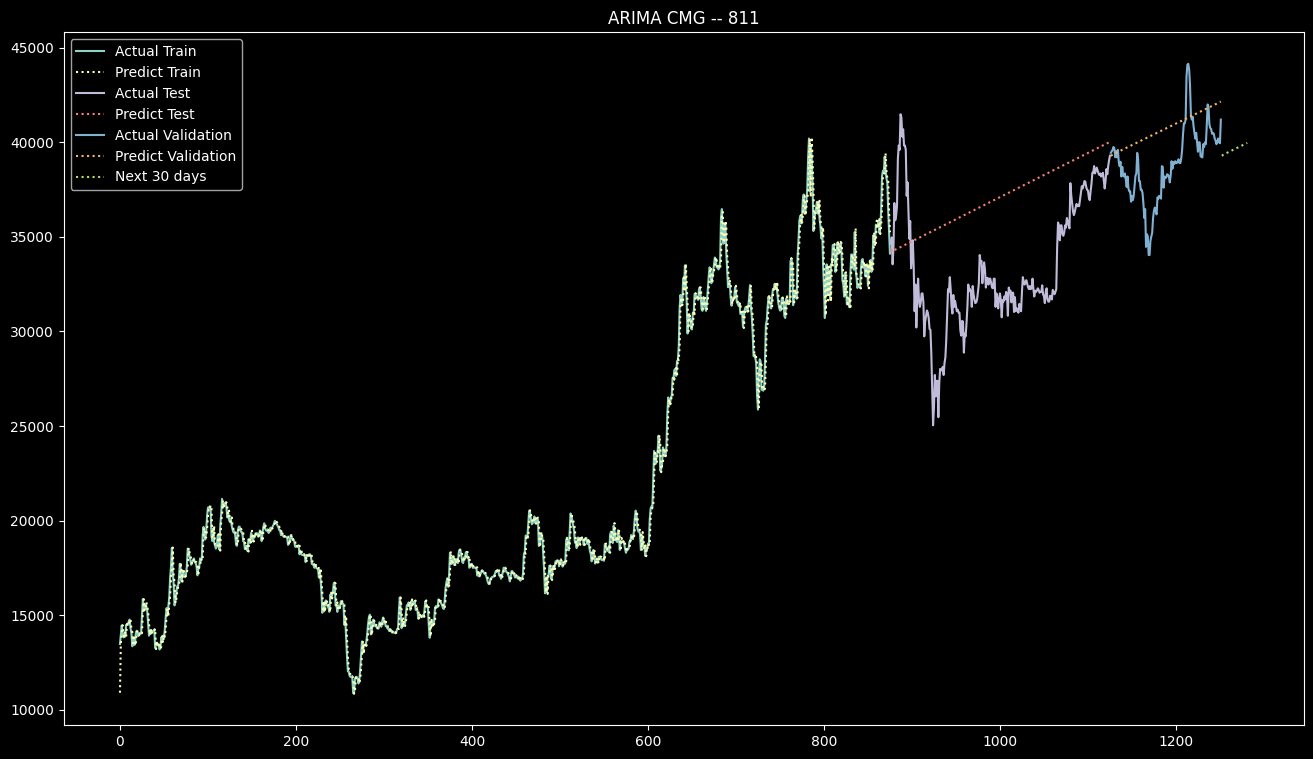

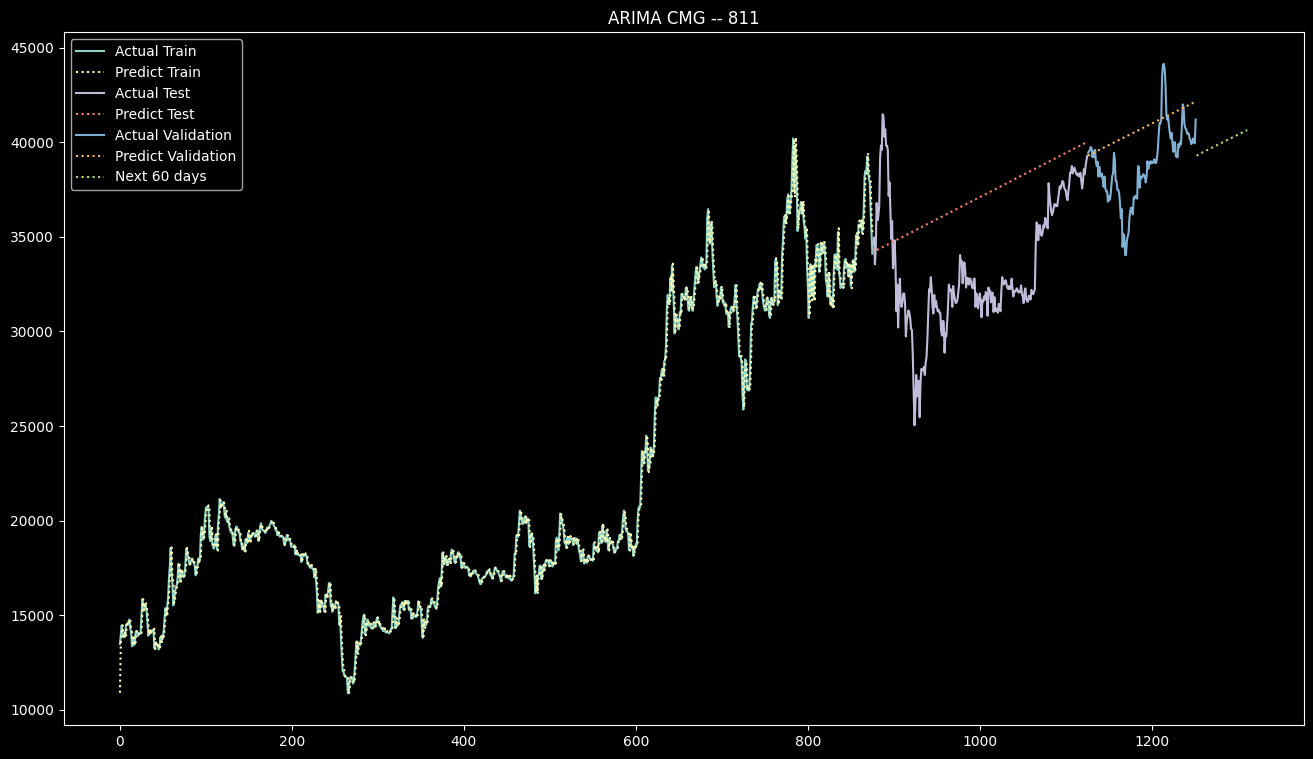

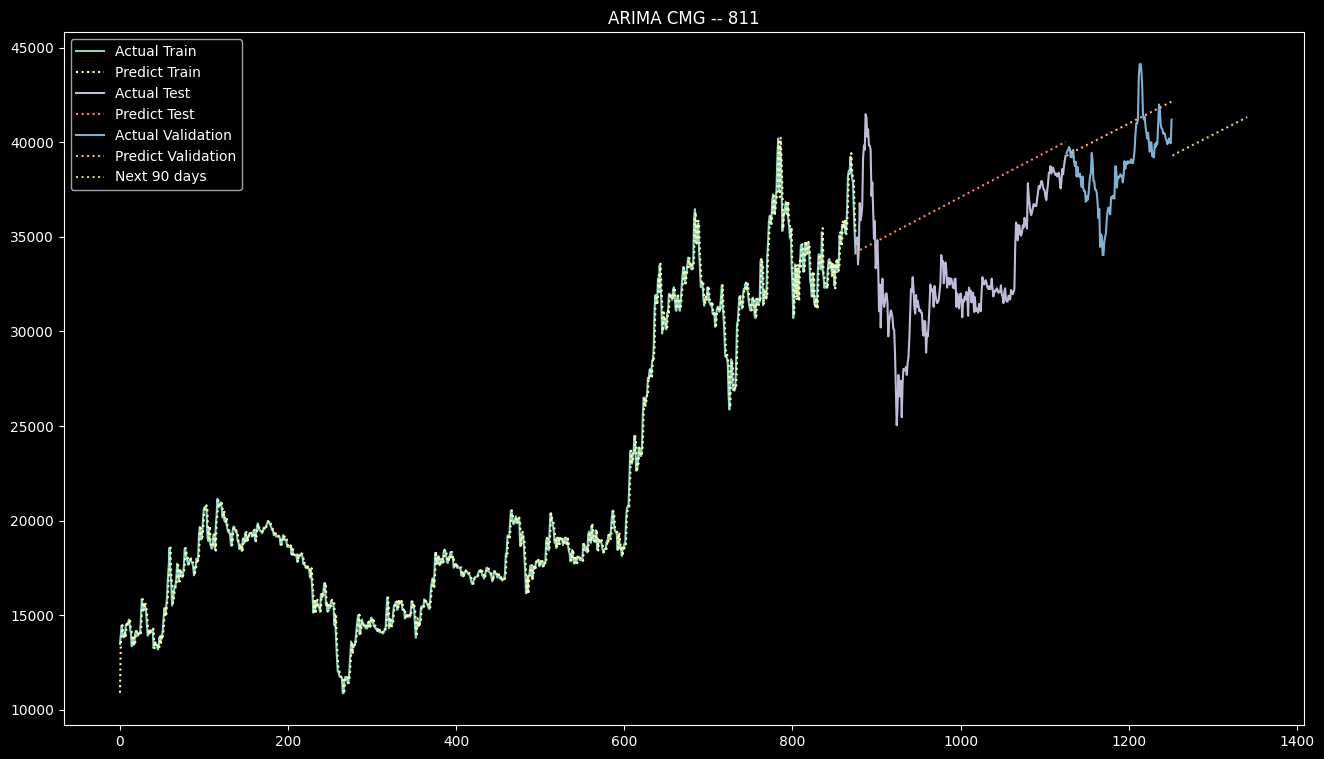

In [24]:
draw_plot(pred_future_30, 30)
draw_plot(pred_future_60, 60)
draw_plot(pred_future_90, 90)